<a href="https://colab.research.google.com/github/DGkurnia/imgclasi/blob/main/sampel_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [ ]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [ ]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adehusen","key":"90be1a1615b8edb07cfad9bc24a9ed92"}'}

In [ ]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d marquis03/flower-classification
!unzip flower-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/iris/17858672081_4b4d071116_c.jpg  
  inflating: train/iris/17885928250_451875aec2_c.jpg  
  inflating: train/iris/17948299355_2161a031db_c.jpg  
  inflating: train/iris/17959086836_3e706d918b_c.jpg  
  inflating: train/iris/18054931376_23052f68d0_c.jpg  
  inflating: train/iris/18059533553_186ccb451a_c.jpg  
  inflating: train/iris/18076633321_400ea17b5a_c.jpg  
  inflating: train/iris/18120244292_ea11fcc9c5_c.jpg  
  inflating: train/iris/181379030_afebe26851_c.jpg  
  inflating: train/iris/18141122602_118114762d_c.jpg  
  inflating: train/iris/18256508742_af6a8f4222_c.jpg  
  inflating: train/iris/18280071332_c6bc90d75a_c.jpg  
  inflating: train/iris/18348714266_33a7bf205f_c.jpg  
  inflating: train/iris/18504796248_9548f45757_c.jpg  
  inflating: train/iris/18519018712_9ae5d4be08_c.jpg  
  inflating: train/iris/18551525352_70323e50e0_c.jpg  
  inflating: train/iris/18607022104_4ae51cd825_c.jpg  
  inflating: tra

In [ ]:
import os
import shutil

In [ ]:
# Direktori awal untuk train dan test
train_dir = "train"
test_dir = "val"

# Direktori baru untuk dataset gabungan
combined_dir = "flower/dataset"

In [ ]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

In [ ]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

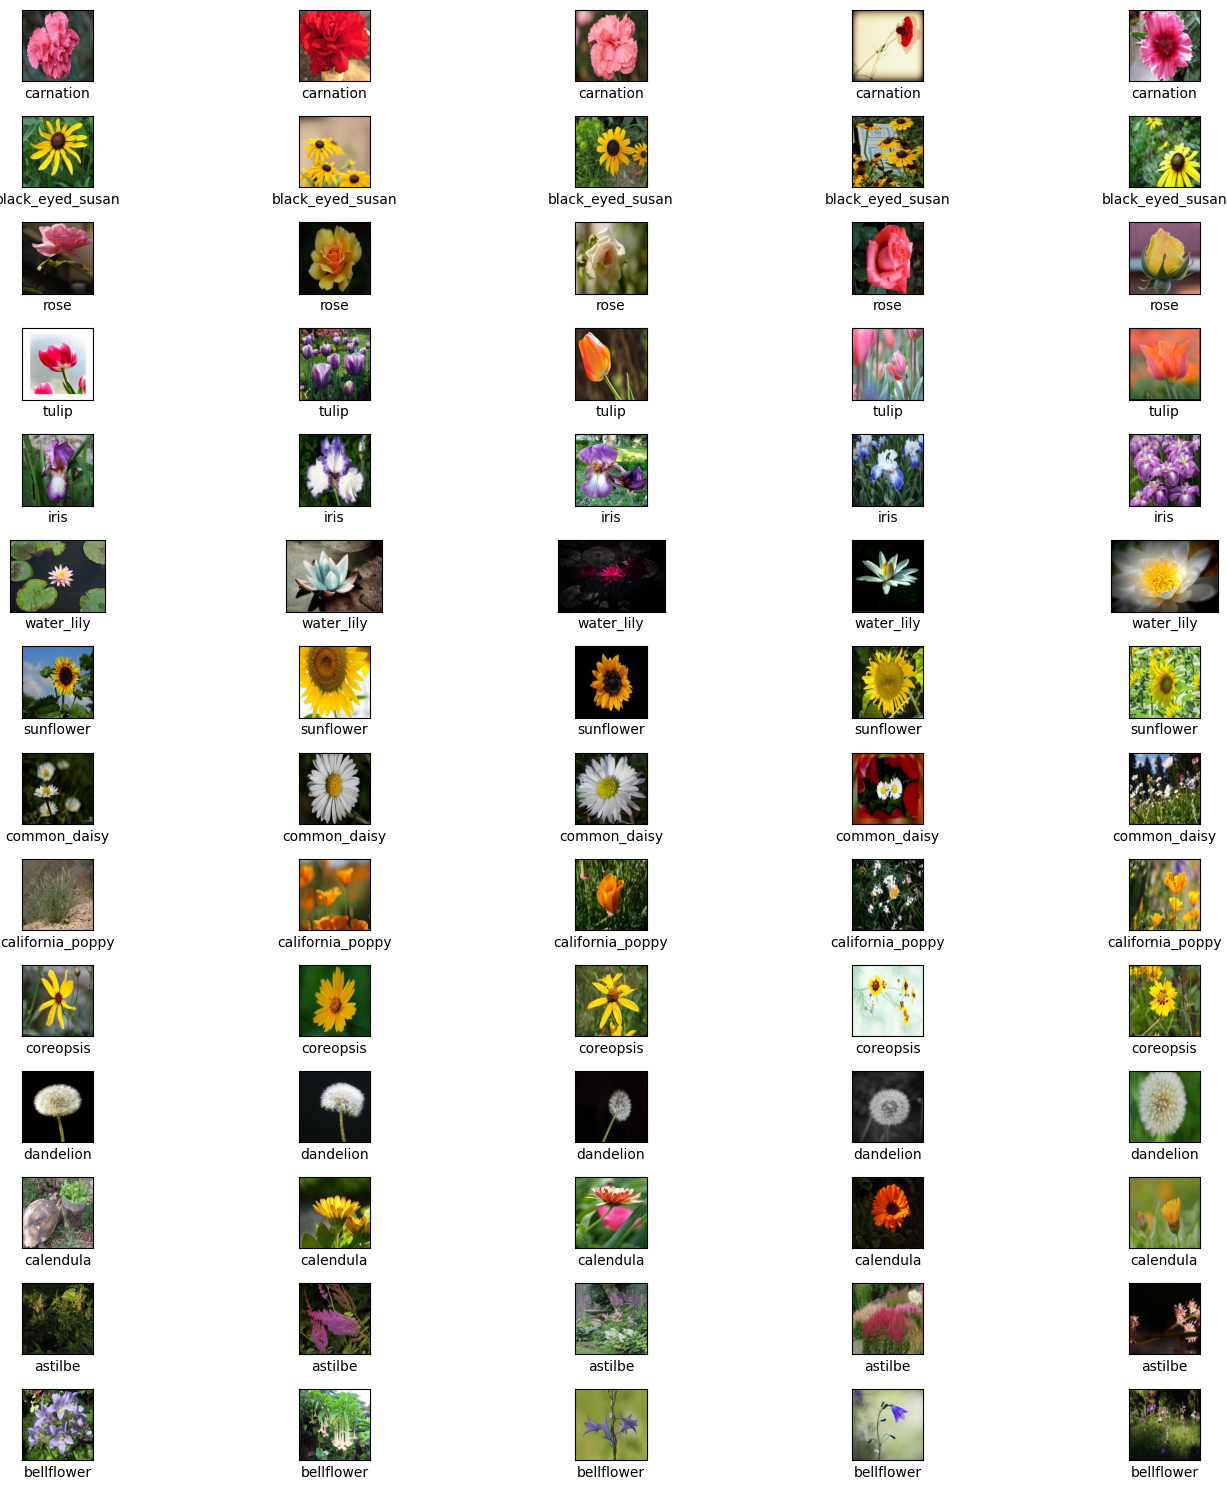

In [ ]:
import matplotlib.pyplot as plt
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
flower_image = {}

# Tentukan path sumber train
path = "flower/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    flower_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = "flower/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(flower_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(flower_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path) # Konversi menjadi skala keabuan
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

labels
iris                1048
dandelion           1045
coreopsis           1042
tulip               1041
california_poppy    1028
sunflower           1020
calendula           1018
black_eyed_susan     993
rose                 993
common_daisy         985
water_lily           984
carnation            931
bellflower           879
astilbe              733
Name: count, dtype: int64


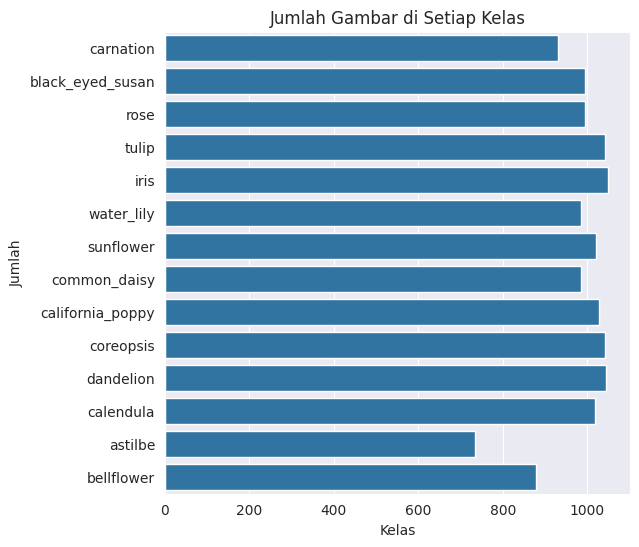

In [ ]:
import seaborn as sns
# Definisikan path sumber
flower_path = "flower/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(flower_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

label = distribution_train['labels'].value_counts()
plt.title('Jumlah Gambar di Setiap Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
print(label)

In [ ]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [ ]:
# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    # 'warp shift': warp_shift,
                    # 'blurring image': blur_image,
                    # 'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    # 'shear image': sheared
                  }

images_path="flower/dataset" # Path untuk gambar asli
augmented_path="flower/augmentasi" # Path untuk gambar yang sudah diaugmentasi
images=[] # Penyimpanan gambar yang telah melalui pra-pemrosesan

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for root, _, files in os.walk(images_path): # Use os.walk to iterate through subfolders
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')): # Check if the file is an image
            images.append(os.path.join(root, file)) # Append full path of image to images list

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi, jumlahnya disesuaikan sesuai kebutuhan
# Variabel untuk melakukan iterasi sampai jumlah gambar yang ditentukan dalam images_to_generate
images_to_generate=2000
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

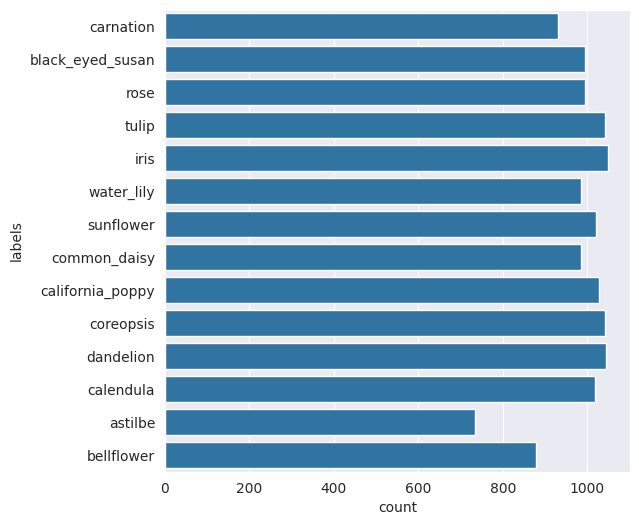

In [ ]:
# Definisikan path sumber
lung_path = "flower/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [ ]:
# prompt: hapus folder dataset astilbe dan bellflower

import shutil

folders_to_remove = ["dataset/astilbe", "dataset/bellflower"]

for folder in folders_to_remove:
  full_path = os.path.join("flower", folder)
  if os.path.exists(full_path):
    shutil.rmtree(full_path)
    print(f"Folder '{full_path}' removed successfully.")
  else:
    print(f"Folder '{full_path}' does not exist.")


In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'flower/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
astilbe,733
bellflower,879
black_eyed_susan,993
calendula,1018
california_poppy,1028
carnation,931
common_daisy,985
coreopsis,1042
dandelion,1045


In [ ]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [ ]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "flower/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels          
test   astilbe             167
       bellflower          162
       black_eyed_susan    195
       calendula           201
       california_poppy    234
       carnation           175
       common_daisy        205
       coreopsis           207
       dandelion           223
       iris                197
       rose                194
       sunflower           202
       tulip               191
       water_lily          195
train  astilbe             566
       bellflower          717
       black_eyed_susan    798
       calendula           817
       california_poppy    794
       carnation           756
       common_daisy        780
       coreopsis           835
       dandelion           822
       iris                851
       rose                799
       sunflower           818
       tulip               850
       water_lily          789
dtype: int64 


                                                    path            labels  \
1214   flower

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [ ]:
# Definisikan direktori training dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

# Define paths for flower categories in training set
train_iris = os.path.join(TRAIN_DIR + '/iris')
train_dandelion = os.path.join(TRAIN_DIR + '/dandelion')
train_coreopsis = os.path.join(TRAIN_DIR + '/coreopsis')
train_tulip = os.path.join(TRAIN_DIR + '/tulip')
train_california_poppy = os.path.join(TRAIN_DIR + '/california_poppy')
train_sunflower = os.path.join(TRAIN_DIR + '/sunflower')
train_calendula = os.path.join(TRAIN_DIR + '/calendula')
train_rose = os.path.join(TRAIN_DIR + '/rose')
train_black_eyed_susan = os.path.join(TRAIN_DIR + '/black_eyed_susan')
train_common_daisy = os.path.join(TRAIN_DIR + '/common_daisy')
train_water_lily = os.path.join(TRAIN_DIR + '/water_lily')
train_carnation = os.path.join(TRAIN_DIR + '/carnation')
train_bellflower = os.path.join(TRAIN_DIR + '/bellflower')
train_astilbe = os.path.join(TRAIN_DIR + '/astilbe')

# Define paths for flower categories in testing set
test_iris = os.path.join(TEST_DIR + '/iris')
test_dandelion = os.path.join(TEST_DIR + '/dandelion')
test_coreopsis = os.path.join(TEST_DIR + '/coreopsis')
test_tulip = os.path.join(TEST_DIR + '/tulip')
test_california_poppy = os.path.join(TEST_DIR + '/california_poppy')
test_sunflower = os.path.join(TEST_DIR + '/sunflower')
test_calendula = os.path.join(TEST_DIR + '/calendula')
test_rose = os.path.join(TEST_DIR + '/rose')
test_black_eyed_susan = os.path.join(TEST_DIR + '/black_eyed_susan')
test_common_daisy = os.path.join(TEST_DIR + '/common_daisy')
test_water_lily = os.path.join(TEST_DIR + '/water_lily')
test_carnation = os.path.join(TEST_DIR + '/carnation')
test_bellflower = os.path.join(TEST_DIR + '/bellflower')
test_astilbe = os.path.join(TEST_DIR + '/astilbe')

# Print image counts for each flower category in training set
print("Total number of iris images in training set: ", len(os.listdir(train_iris)))
print("Total number of dandelion images in training set: ", len(os.listdir(train_dandelion)))
print("Total number of coreopsis images in training set: ", len(os.listdir(train_coreopsis)))
print("Total number of tulip images in training set: ", len(os.listdir(train_tulip)))
print("Total number of california_poppy images in training set: ", len(os.listdir(train_california_poppy)))
print("Total number of sunflower images in training set: ", len(os.listdir(train_sunflower)))
print("Total number of calendula images in training set: ", len(os.listdir(train_calendula)))
print("Total number of rose images in training set: ", len(os.listdir(train_rose)))
print("Total number of black_eyed_susan images in training set: ", len(os.listdir(train_black_eyed_susan)))
print("Total number of common_daisy images in training set: ", len(os.listdir(train_common_daisy)))
print("Total number of water_lily images in training set: ", len(os.listdir(train_water_lily)))
print("Total number of carnation images in training set: ", len(os.listdir(train_carnation)))

# Print image counts for each flower category in testing set
print("Total number of iris images in test set: ", len(os.listdir(test_iris)))
print("Total number of dandelion images in test set: ", len(os.listdir(test_dandelion)))
print("Total number of coreopsis images in test set: ", len(os.listdir(test_coreopsis)))
print("Total number of tulip images in test set: ", len(os.listdir(test_tulip)))
print("Total number of california_poppy images in test set: ", len(os.listdir(test_california_poppy)))
print("Total number of sunflower images in test set: ", len(os.listdir(test_sunflower)))
print("Total number of calendula images in test set: ", len(os.listdir(test_calendula)))
print("Total number of rose images in test set: ", len(os.listdir(test_rose)))
print("Total number of black_eyed_susan images in test set: ", len(os.listdir(test_black_eyed_susan)))
print("Total number of common_daisy images in test set: ", len(os.listdir(test_common_daisy)))
print("Total number of water_lily images in test set: ", len(os.listdir(test_water_lily)))
print("Total number of carnation images in test set: ", len(os.listdir(test_carnation)))

Total number of iris images in training set:  948
Total number of dandelion images in training set:  985
Total number of coreopsis images in training set:  984
Total number of tulip images in training set:  928
Total number of california_poppy images in training set:  973
Total number of sunflower images in training set:  956
Total number of calendula images in training set:  974
Total number of rose images in training set:  874
Total number of black_eyed_susan images in training set:  864
Total number of common_daisy images in training set:  913
Total number of water_lily images in training set:  907
Total number of carnation images in training set:  807
Total number of iris images in test set:  306
Total number of dandelion images in test set:  395
Total number of coreopsis images in test set:  374
Total number of tulip images in test set:  259
Total number of california_poppy images in test set:  361
Total number of sunflower images in test set:  349
Total number of calendula images

In [ ]:
# Buat objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=True)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=32,
                                                  target_size=(150,150),
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 9924 images belonging to 14 classes.
Found 2472 images belonging to 14 classes.
Found 4159 images belonging to 14 classes.


In [ ]:
# tf.keras.backend.clear_session()

# # Initialize a Sequential model
# model_1 = Sequential()

# # Input layer and first Convolutional block
# model_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
# model_1.add(BatchNormalization())
# model_1.add(MaxPooling2D((2, 2)))  # Pooling layer after Conv2D

# # Second Convolutional block
# model_1.add(Conv2D(64, (3, 3), activation='relu'))
# model_1.add(BatchNormalization())
# model_1.add(MaxPooling2D((2, 2)))

# # Third Convolutional block
# model_1.add(Conv2D(128, (3, 3), activation='relu'))
# model_1.add(BatchNormalization())
# model_1.add(MaxPooling2D((2, 2)))

# model_1.add(Conv2D(256, (3, 3), activation='relu'))
# model_1.add(BatchNormalization())
# model_1.add(MaxPooling2D((2, 2)))
# # Flatten the output for the Dense layers
# model_1.add(Flatten())

# # Dense layers with Dropout for regularization
# model_1.add(Dense(256, activation='relu'))
# model_1.add(Dropout(0.5))  # Dropout layer added
# model_1.add(Dense(128, activation='relu'))
# model_1.add(Dropout(0.3))


# model_1.add(Dense(12, activation='softmax'))

# # Compile the model
# model_1.compile(optimizer=tf.keras.optimizers.Adam(),
#                  loss='categorical_crossentropy',
#                  metrics=['accuracy'])
# # Print the model summary
# print(model_1.summary())

from tensorflow.keras.applications import VGG16

tf.keras.backend.clear_session()

# Load pre-trained VGG16 model (without the classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the VGG16 base
model_1 = Sequential()
model_1.add(base_model)
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.3))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.3))
model_1.add(Dense(12, activation='softmax'))

# Compile the model
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

print(model_1.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,854,028 (64.29 MB)

 Trainable params: 2,139,340 (8.16 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Training the model
history = model_1.fit(
    train_generator,
    epochs=50,  # You had epochs=100 here, changed to 10 for faster training
    validation_data=validation_generator,
    callbacks=[reduce_lr],
    verbose=1
)

# ... (rest of your code) ...

Epoch 1/75


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


275/275 ━━━━━━━━━━━━━━━━━━━━ 56s 160ms/step - accuracy: 0.1716 - loss: 2.5053 - val_accuracy: 0.5740 - val_loss: 1.5519 - learning_rate: 0.0010
Epoch 2/75
275/275 ━━━━━━━━━━━━━━━━━━━━ 34s 125ms/step - accuracy: 0.4286 - loss: 1.7075 - val_accuracy: 0.7009 - val_loss: 1.0729 - learning_rate: 0.0010
Epoch 3/75
275/275 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - accuracy: 0.5372 - loss: 1.4154 - val_accuracy: 0.7233 - val_loss: 0.9323 - learning_rate: 0.0010
Epoch 4/75
275/275 ━━━━━━━━━━━━━━━━━━━━ 35s 129ms/step - accuracy: 0.5919 - loss: 1.2582 - val_accuracy: 0.7562 - val_loss: 0.8932 - learning_rate: 0.0010
Epoch 5/75
275/275 ━━━━━━━━━━━━━━━━━━━━ 36s 130ms/step - accuracy: 0.6121 - loss: 1.1667 - val_accuracy: 0.7498 - val_loss: 0.8489 - learning_rate: 0.0010
Epoch 6/75
275/275 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - accuracy: 0.6375 - loss: 1.1162 - val_accuracy: 0.7507 - val_loss: 0.8306 - learning_rate: 0.0010
Epoch 7/75
275/275 ━━━━━━━━━━━━━━━━━━━━ 36s 132ms/step - accuracy: 0.6594 - loss:

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-5d66e4e1ded1>", line 4, in <cell line: 0>
    history = model_1.fit(
              ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit
    logs = self.train_function(iterator)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function
    if not opt_outputs.has_value():
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/optional_ops.py", line 176, in has_value
    return gen_option

TypeError: object of type 'NoneType' has no len()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [ ]:
# prompt: createa confusion matrix evalution

import numpy as np
# Predict the labels of the test data
predictions = model_1.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Get the true labels from the test generator
y_true = test_generator.classes

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a classification report
cr = classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys()))

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(cr)

# Visualize the confusion matrix (optional)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
test_generator.reset()

preds_1 = model_1.predict(test_generator,verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['Normal','Pneumonia'], digits=4))